# Tuning G* Calculations

Things to try:

- Using percentiles instead of aggregated burden score
- Using raw values instead of aggregared burden score
- Using a different weight that is distance based rather than border based?

In [ ]:
# Load packages 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns         
import numpy as np
import os
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
from functions import state_gstar
import pprint
from functools import reduce

# Remove max columns
pd.set_option('display.max_columns', None)

In [3]:
# Import data
base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# Complete 2.0 USA file
usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "2.0-codebook.csv"))
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))

/tmp/ipykernel_1079192/2040895413.py:6: DtypeWarning: Columns (1,2,3,79,80,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  usa_v2 = pd.read_csv(os.path.join(base_dir, "data", "usa_v2.csv"))
/tmp/ipykernel_1079192/2040895413.py:9: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [4]:
# comm_v2.head()

In [5]:
# usa_v2 = usa_v2.select_dtypes(exclude=['bool'])

In [6]:
# v2_geo.head()
# geometry, GEOID10

In [7]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for now

comm_states = comm_v2[comm_v2['State/Territory'].isin(state_names)]
comm_states['State/Territory'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [8]:
# my_list = comm_v2.columns.to_list()
# pprint.pprint(my_list, compact=False) 

In [28]:
# Climate Change
cc = comm_states[['Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)', 
            'Expected building loss rate (Natural Hazards Risk Index) (percentile)', 
            'Expected population loss rate (Natural Hazards Risk Index) (percentile)', 
            'Share of properties at risk of flood in 30 years (percentile)', 
            'Share of properties at risk of fire in 30 years (percentile)',
            # 'GEOID10_TRACT',
            'State/Territory',
            'Census tract 2010 ID']]
cc

,Expected agricultural loss rate (Natural Hazards Risk Index) (percentile),Expected building loss rate (Natural Hazards Risk Index) (percentile),Expected population loss rate (Natural Hazards Risk Index) (percentile),Share of properties at risk of flood in 30 years (percentile),Share of properties at risk of fire in 30 years (percentile),State/Territory,Census tract 2010 ID
0,45.0,66.0,76.0,87.0,84.0,Alabama,1001020100
1,21.0,69.0,65.0,89.0,77.0,Alabama,1001020200
2,39.0,54.0,59.0,48.0,78.0,Alabama,1001020300
3,43.0,55.0,62.0,61.0,78.0,Alabama,1001020400
4,53.0,55.0,61.0,25.0,73.0,Alabama,1001020500
...,...,...,...,...,...,...,...
73052,77.0,50.0,52.0,78.0,80.0,Wyoming,56043000200
73053,12.0,23.0,38.0,1.0,69.0,Wyoming,56043000301
73054,85.0,33.0,39.0,75.0,68.0,Wyoming,56043000302
73055,52.0,84.0,81.0,55.0,91.0,Wyoming,56045951100


In [29]:
cc_test = comm_states[comm_states.columns.isin(cc.columns)]
cc_test
# comm_states = comm_v2[comm_v2['State/Territory'].isin(state_names)]


ValueError: Item wrong length 136 instead of 72360.

In [ ]:

cc =cc.rename(columns={
    'Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)':'ag_loss', 
    'Expected building loss rate (Natural Hazards Risk Index) (percentile)':'building_loss', 
    'Expected population loss rate (Natural Hazards Risk Index) (percentile)':'population_loss', 
    'Share of properties at risk of flood in 30 years (percentile)':'flood_risk', 
    'Share of properties at risk of fire in 30 years (percentile)':'fire_risk',
    'Census tract 2010 ID':'tract_id',
    'State/Territory':'state'
})
cc['cc_mean'] = cc[['ag_loss', 'building_loss', 'population_loss', 'flood_risk', 'fire_risk']].mean(axis=1)

cc.head()

In [10]:
# Energy
energy = comm_states[['Energy burden (percentile)', 'PM2.5 in the air (percentile)', 'Census tract 2010 ID']]
energy = energy.rename(columns={
    'Energy burden (percentile)':'energy_burden', 
    'PM2.5 in the air (percentile)':'pm_25',
    'Census tract 2010 ID':'tract_id'
    })
energy['energy_mean'] = energy[['energy_burden', 'pm_25']].mean(axis=1)

energy.head()


,energy_burden,pm_25,tract_id,energy_mean
0,49.0,67.0,1001020100,58.0
1,6.0,68.0,1001020200,37.0
2,68.0,68.0,1001020300,68.0
3,63.0,69.0,1001020400,66.0
4,38.0,69.0,1001020500,53.5


In [11]:
# Housing
housing = comm_states[['Housing burden (percent) (percentile)', 
                'Share of homes with no kitchen or indoor plumbing (percentile)', 
                'Percent pre-1960s housing (lead paint indicator) (percentile)',
                'Census tract 2010 ID']]
housing = housing.rename(columns={
    'Housing burden (percent) (percentile)':'housing_burden',
    'Share of homes with no kitchen or indoor plumbing (percentile)':'no_plumbing', 
    'Percent pre-1960s housing (lead paint indicator) (percentile)':'lead_paint',
    'Census tract 2010 ID':'tract_id'
})
housing['housing_mean'] = housing[['housing_burden', 'no_plumbing', 'lead_paint']].mean(axis=1)

housing.head()

,housing_burden,no_plumbing,lead_paint,tract_id,housing_mean
0,50.0,0.52,41.0,1001020100,30.506667
1,56.0,0.21,43.0,1001020200,33.070000
2,46.0,0.21,22.0,1001020300,22.736667
3,28.0,0.65,31.0,1001020400,19.883333
4,46.0,0.95,1.0,1001020500,15.983333


In [12]:
# Health
health = comm_states[['Current asthma among adults aged greater than or equal to 18 years (percentile)', 
                'Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile)', 
                'Coronary heart disease among adults aged greater than or equal to 18 years (percentile)',
                'Low life expectancy (percentile)',
                'Census tract 2010 ID']]
health = health.rename(columns={
    'Current asthma among adults aged greater than or equal to 18 years (percentile)':'asthma', 
    'Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile)':'diabetes', 
    'Coronary heart disease among adults aged greater than or equal to 18 years (percentile)':'heart_disease',
    'Low life expectancy (percentile)':'low_life_expectancy',
    'Census tract 2010 ID':'tract_id'
})
health['health_mean'] = health[['asthma', 'diabetes', 'heart_disease', 'low_life_expectancy']].mean(axis=1)

health.head()

,asthma,diabetes,heart_disease,low_life_expectancy,tract_id,health_mean
0,57.0,60.0,59.0,89.0,1001020100,66.250000
1,82.0,83.0,49.0,65.0,1001020200,69.750000
2,65.0,66.0,60.0,NaN,1001020300,63.666667
3,27.0,55.0,66.0,77.0,1001020400,56.250000
4,37.0,34.0,31.0,41.0,1001020500,35.750000


In [13]:
# Legacy Pollution
lp = comm_states[['Is there at least one abandoned mine in this census tract?', 
            'Is there at least one Formerly Used Defense Site (FUDS) in the tract?', 
            'Proximity to hazardous waste sites (percentile)', 
            'Proximity to NPL (Superfund) sites (percentile)', 
            'Proximity to Risk Management Plan (RMP) facilities (percentile)',
            'Census tract 2010 ID']]
lp = lp.rename(columns={
    'Is there at least one abandoned mine in this census tract?':'abandoned_mines', 
    'Is there at least one Formerly Used Defense Site (FUDS) in the tract?':'defense_site', 
    'Proximity to hazardous waste sites (percentile)':'hazardous_waste', 
    'Proximity to NPL (Superfund) sites (percentile)':'superfund_sites', 
    'Proximity to Risk Management Plan (RMP) facilities (percentile)':'rmp_facilites',
    'Census tract 2010 ID':'tract_id'
})
lp['lp_mean'] = lp[['abandoned_mines', 'defense_site', 'hazardous_waste', 'superfund_sites', 'rmp_facilites']].mean(axis=1)

lp.head()

,abandoned_mines,defense_site,hazardous_waste,superfund_sites,rmp_facilites,tract_id,lp_mean
0,NaN,NaN,42.0,52.0,11.0,1001020100,35.0
1,NaN,NaN,50.0,55.0,12.0,1001020200,39.0
2,NaN,NaN,59.0,57.0,12.0,1001020300,42.666667
3,NaN,False,69.0,60.0,13.0,1001020400,35.5
4,NaN,NaN,56.0,64.0,13.0,1001020500,44.333333


In [14]:
# Transportation
transport = comm_states[['Diesel particulate matter exposure (percentile)', 
                    'DOT Travel Barriers Score (percentile)', 
                    'Traffic proximity and volume (percentile)',
                    'Census tract 2010 ID']]
transport = transport.rename(columns={
    'Diesel particulate matter exposure (percentile)':'diesel_pm', 
    'DOT Travel Barriers Score (percentile)':'travel_barriers', 
    'Traffic proximity and volume (percentile)':'traffic_proximity',
    'Census tract 2010 ID':'tract_id'
})
transport['transport_mean'] = transport[['diesel_pm', 'travel_barriers', 'traffic_proximity']].mean(axis=1)

transport.head()

,diesel_pm,travel_barriers,traffic_proximity,tract_id,transport_mean
0,33.0,70.0,15.0,1001020100,39.333333
1,37.0,88.0,36.0,1001020200,53.666667
2,45.0,50.0,37.0,1001020300,44.000000
3,55.0,17.0,64.0,1001020400,45.333333
4,61.0,6.0,43.0,1001020500,36.666667


In [15]:
# Waste and Wastewater
ww = comm_states[['Leaky underground storage tanks (percentile)', 'Wastewater discharge (percentile)', 'Census tract 2010 ID']]
ww =ww.rename(columns={
    'Leaky underground storage tanks (percentile)':'leaky_storage_tanks', 
    'Wastewater discharge (percentile)':'wastewater_discharge',
    'Census tract 2010 ID':'tract_id'
})
ww['ww_mean'] = ww[['leaky_storage_tanks', 'wastewater_discharge']].mean(axis=1)

ww.head()

,leaky_storage_tanks,wastewater_discharge,tract_id,ww_mean
0,26.0,NaN,1001020100,26.0
1,57.0,NaN,1001020200,57.0
2,52.0,NaN,1001020300,52.0
3,65.0,NaN,1001020400,65.0
4,55.0,10.0,1001020500,32.5


In [16]:
# Workforce Development
wd = comm_states[['Linguistic isolation (percent) (percentile)', 
            'Low median household income as a percent of area median income (percentile)', 
            'Percent of individuals below 200% Federal Poverty Line (percentile)', 
            'Unemployment (percent) (percentile)',
            'Census tract 2010 ID']]
wd = wd.rename(columns={
    'Linguistic isolation (percent) (percentile)':'ling_isolation', 
    'Low median household income as a percent of area median income (percentile)':'low_income', 
    'Percent of individuals below 200% Federal Poverty Line (percentile)':'poverty', 
    'Unemployment (percent) (percentile)':'unemployment',
    'Census tract 2010 ID':'tract_id'
})
wd['wd_mean'] = wd[['ling_isolation', 'low_income', 'poverty', 'unemployment']].mean(axis=1)

wd.head()

,ling_isolation,low_income,poverty,unemployment,tract_id,wd_mean
0,12.0,29.0,44.0,22.0,1001020100,26.75
1,12.0,61.0,72.0,44.0,1001020200,47.25
2,12.0,38.0,47.0,32.0,1001020300,32.25
3,58.0,30.0,31.0,27.0,1001020400,36.50
4,54.0,22.0,29.0,26.0,1001020500,32.75


In [17]:
# Concat without ids
# dfs = [cc, health, housing, energy, lp, transport, ww, wd]
# complete = pd.concat(dfs, axis=1)
# complete.head()

In [18]:
# Merge using tract ID
# dfs = [cc, health, housing, energy, lp, transport, ww, wd]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['tract_id'],
#                                             how='outer'), 
#                                             dfs)
# df_merged = df_merged.set_index('tract_id')
# df_merged.head()
# df_merged.shape

In [19]:
# geometry, GEOID10
geo_join = v2_geo[['GEOID10', 'geometry']].rename(columns={'GEOID10':'tract_id'})
geo_join['tract_id'] =geo_join['tract_id'].astype('int64')

# Merge with geodf
cc = pd.merge(cc, geo_join, how='left', on='tract_id')

# Reassert GDF
cc =gpd.GeoDataFrame(cc)
type(cc)

geopandas.geodataframe.GeoDataFrame

In [20]:
# Drop geometry NAs
cc_clean = cc[(cc.geometry.type == 'Polygon') |( cc.geometry.type == 'MultiPolygon')]

# Confirm our geometries are correct
cc_clean.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [21]:
# Drop NAs from mean column
cc_clean = cc_clean.dropna(subset=['cc_mean'])
# cc_clean.isna().sum()


In [22]:
# cc_clean.plot()

In [23]:
# Create weights using Queen method 
w = lps.weights.Queen(cc_clean['geometry'])

# Run the Getis Ord test for burdens
g_local = G_Local(cc_clean['cc_mean'], w=w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 7 islands with ids: 10295, 11370, 16266, 32082, 32764, 57699, 57846.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 10295, ' is an island (no neighbors)')
('WARNING: ', 11370, ' is an island (no neighbors)')
('WARNING: ', 16266, ' is an island (no neighbors)')
('WARNING: ', 32082, ' is an island (no neighbors)')
('WARNING: ', 32764, ' is an island (no neighbors)')
('WARNING: ', 57699, ' is an island (no neighbors)')
('WARNING: ', 57846, ' is an island (no neighbors)')


/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [24]:
# Add statistics to to a new df
results = cc_clean.copy()
results['standardized_gstar'] = g_local.Zs 
results['p_norm'] = g_local.p_norm # p-value assuming normal distribution
results['p_sim'] = g_local.p_sim
results['p_sim'].describe()

count    72064.000000
mean         0.121959
std          0.147696
min          0.000100
25%          0.002200
50%          0.048000
75%          0.213500
max          0.500000
Name: p_sim, dtype: float64

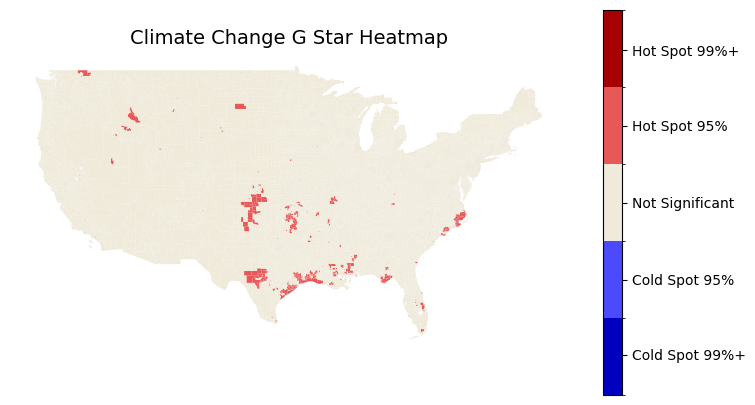

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define 5 distinct colors
colors = ["#0000bf", "#4b4bfd", "#efeada", "#e85858", "#a60202"]  # Dark Blue, Blue, Tan, Red, Dark Red

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
# bounds = [0, 1, 2, 3, 4, 5]  # 5 bins
bounds = [-3, -2.58, -1.96, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Climate Change G Star Heatmap',
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results.plot(ax=ax,
                column='standardized_gstar',
                cmap=cmap,
                norm=norm,
                legend=False)
                # legend_kwds={
                #     'label':'Number of Burdens'
                # })


# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax)

# # Modify the colorbar tick labels
cbar.set_ticks([-2.78, -2.27, 0, 2.27, 2.78])
cbar.set_ticklabels(['Cold Spot 99%+', 'Cold Spot 95%', 'Not Significant', 'Hot Spot 95%', 'Hot Spot 99%+']) 

plt.show()